# A notebook to create the dataset

In [18]:
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class RobotTrajectoryDataset(Dataset):
    """
    PyTorch Dataset for robot trajectory sequences sliding window over a DataFrame.
    """
    
    def __init__(self, df, input_steps=20, target_steps=10):
        """
        Initialize the dataset.
        
        Args:
            df: DataFrame containing the trajectory data (columns: vx, vy, omega, etc.)
            input_steps (int): Number of input steps
            target_steps (int): Number of target steps
        """
        self.input_steps = input_steps
        self.target_steps = target_steps
        self.sequence_length = input_steps + target_steps
        
        # Helper to get numpy array from column if exists, preferably filtered/estimated
        def get_col(names):
            for name in names:
                if name in df.columns:
                    return df[name].values.astype(np.float32)
            raise ValueError(f"Could not find any of {names} in dataframe columns: {df.columns}")

        # Extract columns as numpy arrays for fast access
        self.vx = get_col(['vx'])
        self.vy = get_col(['vy'])
        self.omega = get_col(['omega'])
        
        self.vx_cmd = get_col(['vx_cmd'])
        self.vy_cmd = get_col(['vy_cmd'])
        self.omega_cmd = get_col(['omega_cmd'])
        
        # Only keep theta, remove x and y
        self.theta = get_col(['filtered_theta', 'theta', 'Orientation'])
        
        self.data_len = len(df)
        
        # Calculate number of possible sequences
        # We slide the window by 1 step
        self.num_sequences = max(0, self.data_len - self.sequence_length + 1)
    
    def __len__(self):
        """Returns the total number of sequences."""
        return self.num_sequences
    
    def __getitem__(self, idx):
        """
        Returns a single sample as tensors.
        
        Args:
            idx (int): Index of the sample (start index of the sliding window)
            
        Returns:
            dict: Dictionary containing:
                - 'input_x': Tensor of shape (input_steps, 7) - [vx, vy, omega, vx_cmd, vy_cmd, omega_cmd, theta]
                - 'target_x': Tensor of shape (target_steps, 7) - Same format as input
                - 'sequence_idx': Index of the sample
        """
        # Calculate indices
        start_idx = idx
        mid_idx = idx + self.input_steps
        end_idx = idx + self.sequence_length
        
        # Stack features for the entire window first or slice individually
        # Slicing individually and then stacking is usually fine
        
        # Define feature list for easy stacking
        # Features: [vx, vy, omega, vx_cmd, vy_cmd, omega_cmd, theta]
        
        # Input part
        input_x = np.stack([
            self.vx[start_idx:mid_idx],
            self.vy[start_idx:mid_idx],
            self.omega[start_idx:mid_idx],
            self.vx_cmd[start_idx:mid_idx],
            self.vy_cmd[start_idx:mid_idx],
            self.omega_cmd[start_idx:mid_idx],
            self.theta[start_idx:mid_idx],
        ], axis=1) # (input_steps, 7)
        
        # Target part
        target_x = np.stack([
            self.vx[mid_idx:end_idx],
            self.vy[mid_idx:end_idx],
            self.omega[mid_idx:end_idx],
            self.vx_cmd[mid_idx:end_idx],
            self.vy_cmd[mid_idx:end_idx],
            self.omega_cmd[mid_idx:end_idx],
            self.theta[mid_idx:end_idx],
        ], axis=1) # (target_steps, 7)
        
        return {
            'input_x': torch.from_numpy(input_x),
            'target_x': torch.from_numpy(target_x),
            'sequence_idx': idx
        }


df_dataset = pd.read_csv("../dataset/processed_data/data0.csv")
print(f"Loaded DataFrame with shape: {df_dataset.shape}")
    
# Create dataset
dataset = RobotTrajectoryDataset(
    df_dataset,
    input_steps=50,
    target_steps=500
)

print(f"Dataset size: {len(dataset)}")

Loaded DataFrame with shape: (9033, 11)
Dataset size: 8484


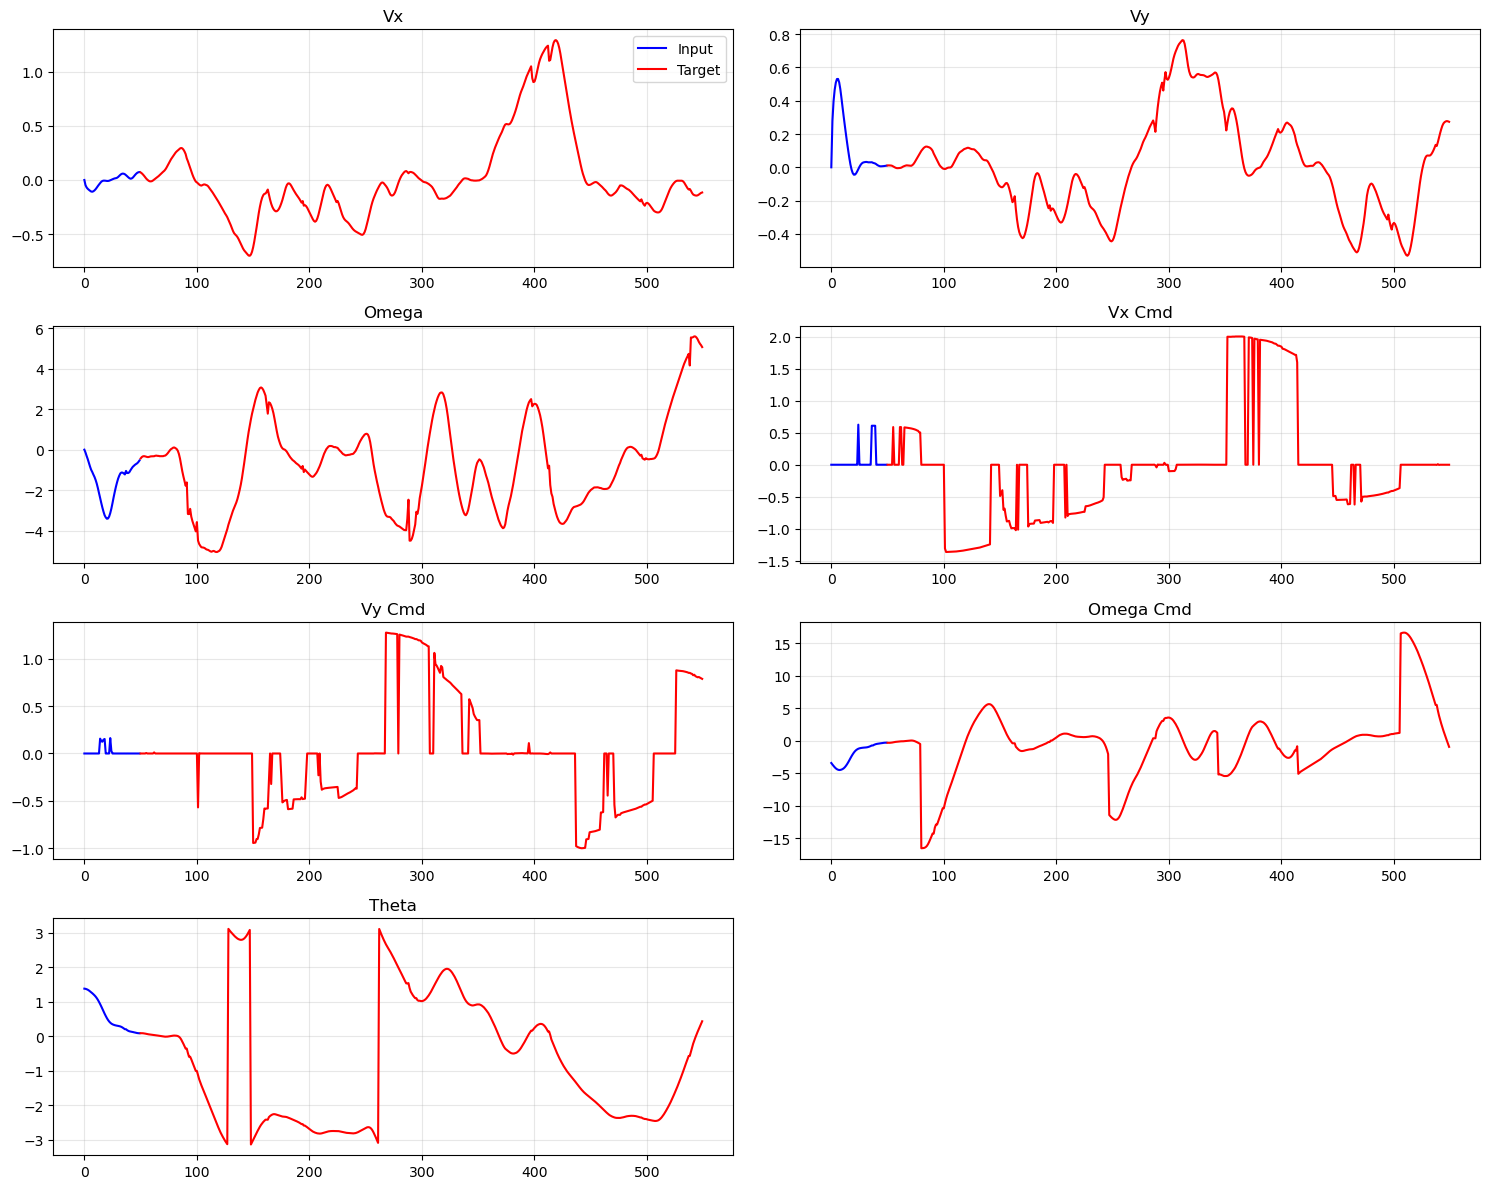

In [19]:
def plot_dataset_sample(dataset, idx=0):
    """
    Plots the trajectories for a given sample index from the dataset.
    Since position is removed, plots Velocity components and Theta.
    """
    sample = dataset[idx]
    
    # Extract features: [vx, vy, omega, vx_cmd, vy_cmd, omega_cmd, theta]
    # input_x: (input_steps, 7)
    # target_x: (target_steps, 7)
    
    features = ['Vx', 'Vy', 'Omega', 'Vx Cmd', 'Vy Cmd', 'Omega Cmd', 'Theta']
    input_data = sample['input_x'].numpy()
    target_data = sample['target_x'].numpy()
    
    input_steps = input_data.shape[0]
    target_steps = target_data.shape[0]
    
    t_input = np.arange(input_steps)
    t_target = np.arange(input_steps, input_steps + target_steps)
    
    fig, axes = plt.subplots(4, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(7):
        ax = axes[i]
        feature_name = features[i]
        
        ax.plot(t_input, input_data[:, i], 'b-', label='Input')
        ax.plot(t_target, target_data[:, i], 'r-', label='Target')
        ax.set_title(feature_name)
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()

    axes[7].axis('off') # Hide unused subplot
    
    plt.tight_layout()
    plt.show()

plot_dataset_sample(dataset, idx=0)

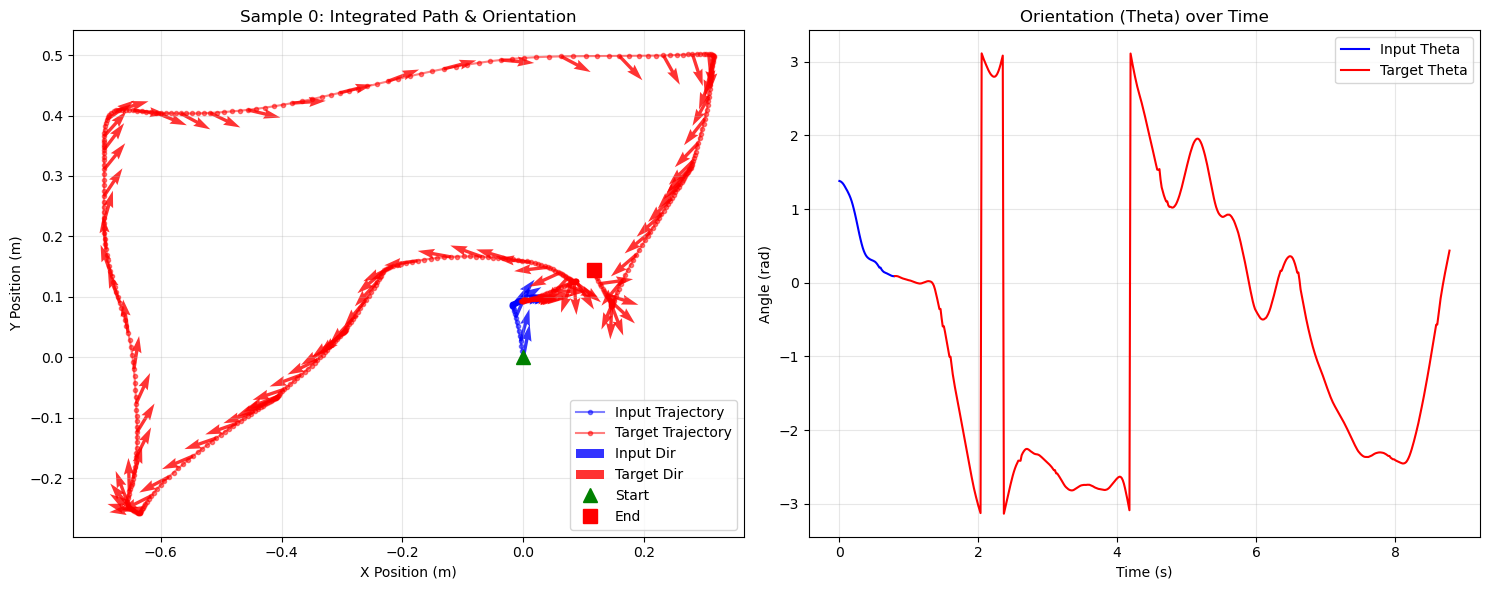

In [22]:
def plot_integrated_trajectory(dataset, idx=0, dt=0.016):
    """
    Plots the integrated trajectory (position) derived from the velocities in the dataset.
    Also plots the orientation (theta) along the path and as a time series.
    """
    sample = dataset[idx]
    
    # Extract velocities (0:vx, 1:vy) and orientation (6:theta)
    input_vx = sample['input_x'][:, 0].numpy()
    input_vy = sample['input_x'][:, 1].numpy()
    input_theta = sample['input_x'][:, 6].numpy()
    
    target_vx = sample['target_x'][:, 0].numpy()
    target_vy = sample['target_x'][:, 1].numpy()
    target_theta = sample['target_x'][:, 6].numpy()
    
    # Integrate Input (trapezoidal or simple Euler)
    # Start at (0,0) relative
    input_x = np.concatenate(([0], np.cumsum(input_vx * dt)))
    input_y = np.concatenate(([0], np.cumsum(input_vy * dt)))
    
    # Integrate Target (continue from last input position)
    start_x = input_x[-1]
    start_y = input_y[-1]
    
    target_x = np.concatenate(([start_x], start_x + np.cumsum(target_vx * dt)))
    target_y = np.concatenate(([start_y], start_y + np.cumsum(target_vy * dt)))
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # --- Plot 1: Integrated Trajectory (X-Y) with Orientation Quivers ---
    ax1.plot(input_x, input_y, 'bo-', label='Input Trajectory', markersize=3, alpha=0.5)
    ax1.plot(target_x, target_y, 'ro-', label='Target Trajectory', markersize=3, alpha=0.5)
    
    # Add orientation arrows (quivers)
    # Subsample to avoid clutter (every 5th step)
    step = 5
    
    # Input arrows: length matches indices of theta
    # input_x has N+1 points. input_theta has N points. 
    # We plot at x[i], y[i] with theta[i]
    ax1.quiver(input_x[:-1][::step], input_y[:-1][::step], 
               np.cos(input_theta[::step]), np.sin(input_theta[::step]), 
               color='blue', scale=20, width=0.005, alpha=0.8, label='Input Dir')
               
    ax1.quiver(target_x[:-1][::step], target_y[:-1][::step], 
               np.cos(target_theta[::step]), np.sin(target_theta[::step]), 
               color='red', scale=20, width=0.005, alpha=0.8, label='Target Dir')
    
    # Mark special points
    ax1.plot(input_x[0], input_y[0], 'g^', markersize=10, label='Start')
    ax1.plot(target_x[-1], target_y[-1], 'rs', markersize=10, label='End')
    
    ax1.set_title(f'Sample {idx}: Integrated Path & Orientation')
    ax1.set_xlabel('X Position (m)')
    ax1.set_ylabel('Y Position (m)')
    ax1.legend(loc='best')
    ax1.axis('equal')
    ax1.grid(True, alpha=0.3)
    
    # --- Plot 2: Orientation vs Time ---
    t_input = np.arange(len(input_theta)) * dt
    t_target = np.arange(len(input_theta), len(input_theta) + len(target_theta)) * dt
    
    ax2.plot(t_input, input_theta, 'b-', label='Input Theta')
    ax2.plot(t_target, target_theta, 'r-', label='Target Theta')
    
    ax2.set_title('Orientation (Theta) over Time')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angle (rad)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Test the function
plot_integrated_trajectory(dataset, idx=0)

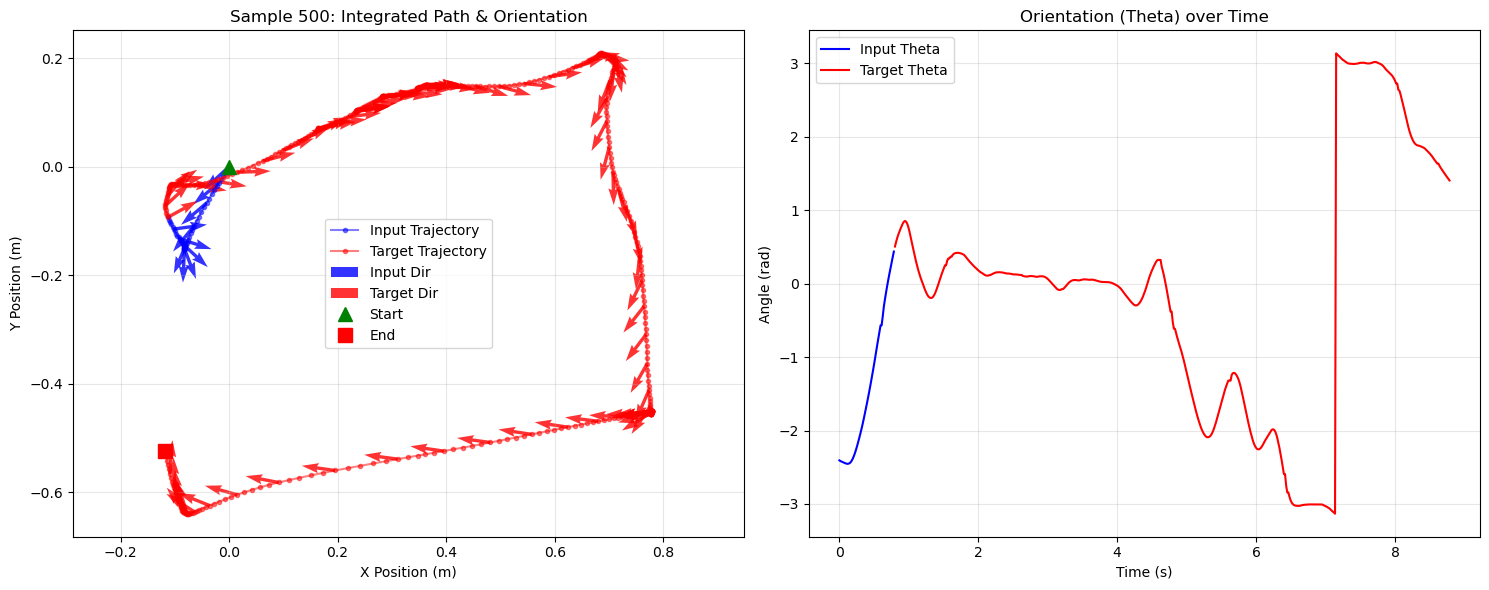

In [30]:
# Test the function
plot_integrated_trajectory(dataset, idx=500)